In [1]:
import numpy as np 
import os
from matplotlib import pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
from scipy import signal
import scipy
import math
# !pip install opencv-python-headless
!pip install opencv-python==3.4.2.17 opencv-contrib-python==3.4.2.17

In [2]:
from google.colab import drive

drive.mount("/content/drive", force_remount=True)
%cd '/content/drive/MyDrive/Colab Notebooks/V&P/assignment'
%ls

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/V&P/assignment
2.jfif                   exercise_11.ipynb  im4.jpg
7.jfif                   exercise_12.ipynb  ImageProcessing_assignment.pdf
8_1im.png                exercise_13.ipynb  isaac.png
8_2im.png                exGenerator.pyc    Lenna.png
BoW.py                   frame1.png         Photos/
Dataset/                 gen_img/           simple.png
Distorted/               im1.jpg            templateAssignment.zip
ExampleGeneration.ipynb  im2.jpg            try1-7Exercise.ipynb
exercise_10.ipynb        im3.jpg


# load images

(490, 360, 3)


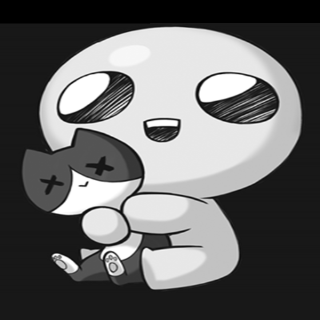

(512, 512, 3)


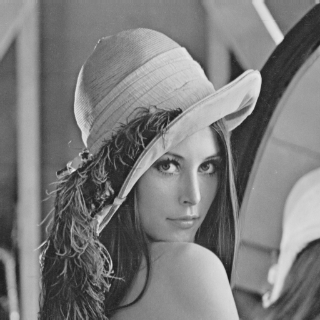

(514, 514, 3)


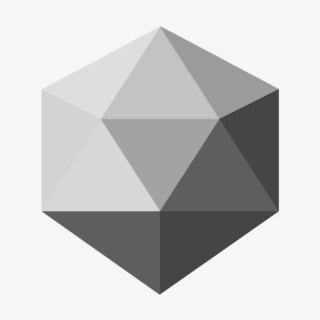

In [3]:
images_paths=["./isaac.png","./Lenna.png","./simple.png"]
images = []
greyscale = True


for path in images_paths:
  img = cv2.imread(path)
  print(img.shape)
  if greyscale:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  else:
    cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(320,320))
  cv2_imshow(img)
  images.append(img)

width = 320
height = 320
img = images[1]

# Laplacian pyramid algorithm


original image


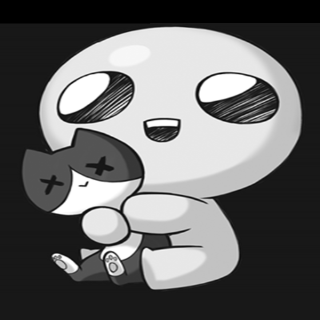

filtered original image


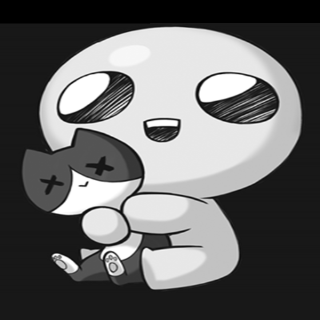

residual 0


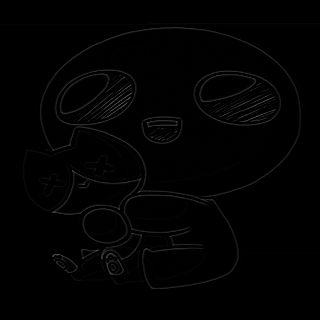

subsample 1


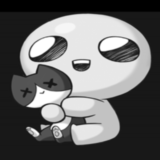

subsample 1 filtered


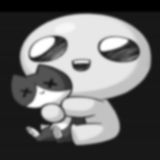

residual 1


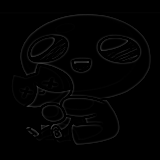

subsample 2


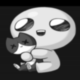

upsample 1 (no residual)


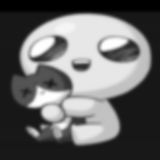

upsample 1


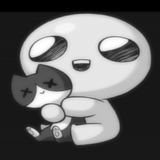

upsample 2 (no residual)


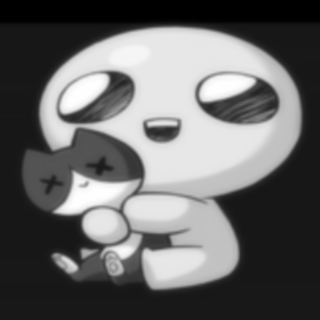

upsample 2


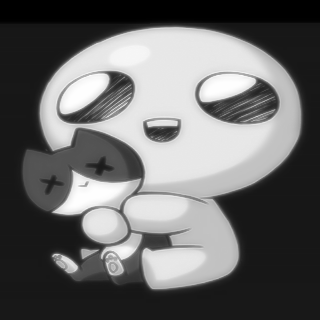


Mean squared error from downsampling: 209.08293424337774

Structural similarity index from downsampling: 0.9165716663403516


In [4]:
def subsample(img):
  width = np.int(img.shape[0]/2)
  height =  np.int(img.shape[1]/2)
  newimg = np.zeros(shape=(width,height))
  ni=-1;nj=-1
  for i, row in enumerate(img):
    if i%2 == 0:
      ni += 1
      for j, column in enumerate(row):
        if j%2==0:
          nj +=1
          newimg[ni, nj] = img[i,j]
      nj = -1
  return newimg


print("original image")
cv2_imshow(img)

# start the downsample phase until a quarter of original resolution
img_blur = cv2.GaussianBlur(img,(5,5),0)
print("filtered original image")
cv2_imshow(img)
residual_0 =  cv2.subtract(img,img_blur)
print("residual 0")
cv2_imshow(residual_0)

img_sub2 = subsample(img_blur)
print("subsample 1")
cv2_imshow(img_sub2)
img_sub2_blur = cv2.GaussianBlur(img_sub2,(5,5),0)
print("subsample 1 filtered")
cv2_imshow(img_sub2_blur)
residual_1 = cv2.subtract(img_sub2,img_sub2_blur) 
print("residual 1")
cv2_imshow(residual_1)

img_sub4 = subsample(img_sub2_blur)
print("subsample 2")
cv2_imshow(img_sub4)

# start the upsampe phase to reach the original resolution
upsample_2 =  cv2.pyrUp(img_sub4, dstsize= (160,160))
print("upsample 1 (no residual)")
cv2_imshow(upsample_2)
upsample_2 = upsample_2 + residual_1
print("upsample 1")
cv2_imshow(upsample_2)

upsample_4 =  cv2.pyrUp(upsample_2, dstsize= (320,320))
print("upsample 2 (no residual)")
cv2_imshow(upsample_4)
upsample_4 = upsample_4 + residual_0
print("upsample 2")
cv2_imshow(upsample_4)

# loss_mse = (abs(img - upsample_4)).mean(axis=None)
# loss_mse= mean_squared_error(img,upsample_4)

loss_mse = ((img- upsample_4)**2).mean(axis=None)
print("\nMean squared error from downsampling: {}".format(loss_mse))

ssim = ssim(img, upsample_4, data_range=(upsample_4.max() - upsample_4.min()))

print("\nStructural similarity index from downsampling: {}".format(ssim))

# Box filtering




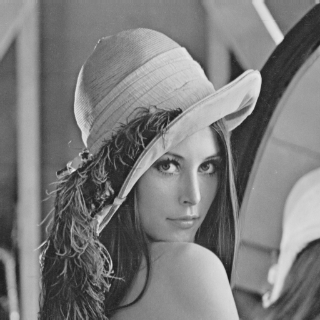

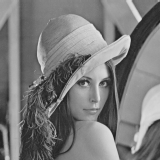

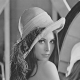

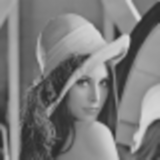

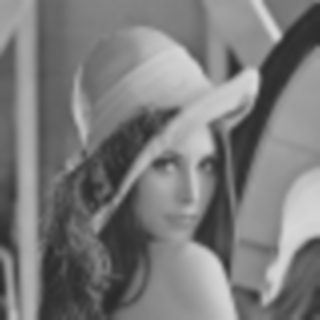

In [4]:
def strideConv(image, s):
    box_filter = np.ones((2,2))/4
    return signal.convolve2d(image, box_filter[::-1, ::-1], mode='valid')[::s, ::s]

cv2_imshow(img)
conv_image = strideConv(img,2)
cv2_imshow(conv_image)
conv_image = strideConv(conv_image,2)
cv2_imshow(conv_image)

# reconstructing the image 

interpolated_Image = cv2.pyrUp(conv_image, dstsize= (int(0.5*width),int(0.5*height)))
cv2_imshow(interpolated_Image)
interpolated_Image = cv2.pyrUp(interpolated_Image, dstsize= (width,height))
cv2_imshow(interpolated_Image)

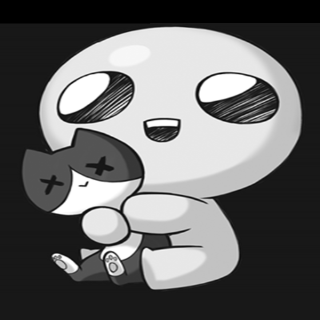

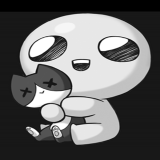

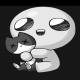

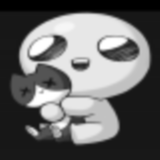

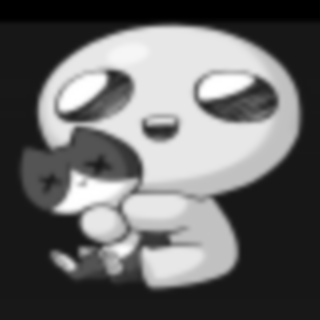


Mean squared error from downsampling: 735.6848200548966

Structural similarity index from downsampling: 0.7712684482530329


In [5]:
# loss_mse = (abs(img - interpolated_Image)).mean(axis=None)
loss_mse = ((img - interpolated_Image)**2).mean(axis=None)
print("\nMean squared error from downsampling: {}".format(loss_mse))

ssim = ssim(img, interpolated_Image, data_range=interpolated_Image.max() - interpolated_Image.min())
print("\nStructural similarity index from downsampling: {}".format(ssim))

# MIPMAP (Grayscale)

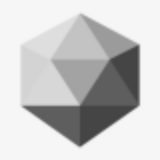

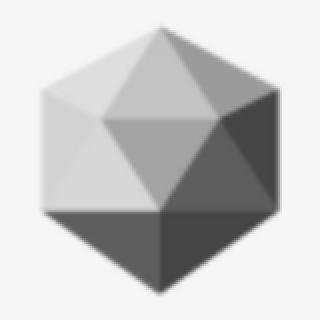


Mean squared error from downsampling: 61.83496976852417

Structural similarity index from downsampling: 0.9342492746604812


In [5]:
if not(greyscale):
  img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# mipmappging usign the box fiter 

def downsample_mipmap(image, sampling_rate):
  if sampling_rate < 2:
    return image

  # calculus of MIP maps
  downsamples = [image]
  for i in range(math.ceil(sampling_rate/2)):
    image = strideConv(image, 2)
    downsamples.append(image)

  second_last= downsamples[-2]
  last= downsamples[-1]
  weight = sampling_rate%2
  new_width = round(width/sampling_rate)
  new_height = round(height/sampling_rate)


  interpolated_second_last = cv2.resize(second_last, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
  interpolated_second_last = cv2.multiply(interpolated_second_last, weight) if weight!=0 else 0
  interpolated_last = cv2.resize(last, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
  interpolated_last = cv2.multiply(interpolated_last, (1-weight)) if not(1-weight)== 0 else 0

  result = cv2.add(interpolated_second_last,interpolated_last)
  return result

img = images[2]

new_resolution = downsample_mipmap(img,2)
new_resolution = downsample_mipmap(new_resolution,2)
cv2_imshow(new_resolution)
original_resolution = cv2.resize(new_resolution, (width, height), interpolation=cv2.INTER_AREA)
# original_resolution= cv2.pyrUp(new_resolution, dstsize= (width,height))
cv2_imshow(original_resolution)


loss_mse = ((img - original_resolution)**2).mean(axis=None)
print("\nMean squared error from downsampling: {}".format(loss_mse))

ssim = ssim(img, original_resolution, data_range=original_resolution.max() - original_resolution.min())
print("\nStructural similarity index from downsampling: {}".format(ssim))

# Content loss before functions

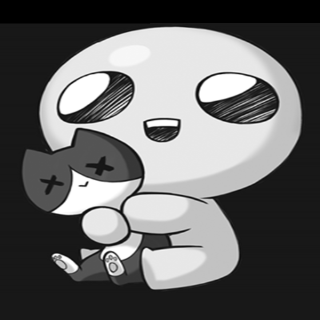

Average entropy for the image n°0 is: 1.8353612994990518


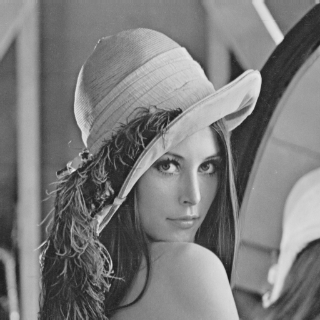

Average entropy for the image n°1 is: 4.446551769498186


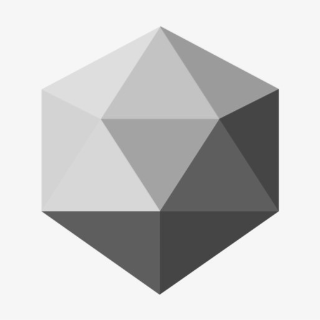

Average entropy for the image n°2 is: 0.5171056182209888


In [6]:
from skimage.filters.rank import entropy
from skimage.morphology import disk

for i,image in enumerate(images): 
  cv2_imshow(image)
  entropy_image = entropy(image, disk(5))
  average_ent = np.sum(entropy_image)/entropy_image.size
  print("Average entropy for the image n°{} is: {}".format(i,average_ent))